<a href="https://colab.research.google.com/github/Oreolorun/Web-Scraping/blob/main/WebScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Importing libraries
from urllib.request import urlopen
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import requests
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#  making or changing directory
FLAG_17 = False

while FLAG_17:
  os.chdir('gdrive/My Drive/Datasets/Car_Images/coupes')
  break

## Tabular Data Scrapping

In [ ]:
#  Scraping names and price
FLAG_5 = False

while FLAG_5:
  url = 'https://www.ebay.com/b/Toyota-Corolla-Cars/6001/bn_24017042'

  hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
        'Accept-Encoding': 'none',
        'Accept-Language': 'en-US,en;q=0.8',
        'Connection': 'keep-alive'}

  request = urllib.request.Request(url, headers=hdr)

  html = urlopen(request)
  bs = BeautifulSoup(html.read(), 'html.parser')

  #  Filtering car names and prices
  car_titles = bs.find_all('h3', attrs={'class':'s-item__title'})
  car_prices = bs.find_all('span', attrs={'class':'s-item__price'})

  #  Creating lists and a dictionary to hold scrapped data
  cars = []
  prices = []
  scrapped = {}

  #  Iterating through car names and appending to list
  for title in car_titles:
    cars.append(title.get_text())

  #  Iterating through car prices and appending to list
  for price in car_prices:
    prices.append(price.get_text())

  #  Creating key, value pairs in dictionary
  scrapped['Car'] = cars
  scrapped['Price'] = prices
  break

In [ ]:
#  Creating dataframe object
#df = pd.DataFrame(scrapped)
#df.head()

In [ ]:
#  Formatting the 'Price' attribute as float
#df.Price = df.Price.map(lambda x: x[1:].replace(',',''))
#df['Price'] = df['Price'].astype(float)
#df.head()

## Ebay

In [ ]:
#  Ebay
FLAG_1 = False

while FLAG_1:
  image_count = 0
  image_src = []

  for i in tqdm(range(1,11)):
    url_2 = f'https://www.dreamstime.com/photos-images/sedan-car.html?pg={str(i)}'

    hdr = {'User-Agent': 'MyApp/1.0',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
        'Accept-Encoding': 'none',
        'Accept-Language': 'en-US,en;q=0.8',
        'Connection': 'keep-alive'}

    request_2 = urllib.request.Request(url_2, headers=hdr)

    html_2 = urlopen(request_2)
    bs_2 = BeautifulSoup(html_2.read(), 'html.parser')

    images = bs_2.find_all('img', attrs={'class':'dt-image'})

    for image in images:
      image_src.append(image['data-src'])
  break

In [ ]:
#  Downloading images
FLAG_2 = False

while FLAG_2:
  image_count = 460
  for image in tqdm(image_src[460:]):
    with open(f'sedan_{str(image_count)}.jpg', 'wb') as f:
      res = requests.get(image)
      f.write(res.content)
    image_count+=1
  break

## **Scraper Class**

In [ ]:
class Scraper:
  """
  This class is used to create an image web scraper
  """
  def __init__(self, header):
    self.header = header

  def scrape(self, url, tag, attribute_dict, pages=1):
    """
    This method extracts img tags. Inspect to extract src.
    """
    images = []
    for i in tqdm(range(pages)):
      request = urllib.request.Request(os.path.join(url, f'?page={str(i)}'), headers= self.header)
      html = urlopen(request)
      bs = BeautifulSoup(html.read(), 'html.parser')
      image_tags = bs.find_all(tag, attrs=attribute_dict)

      for image_tag in image_tags:
        images.append(image_tag)
    
    return images

  def download_images(src_list, directory, prefix='img'):
    """
    This method downloads scraped images into a specified directory
    """
    image_count = 1
    for src in src_list:
      with open(os.path.join(directory, prefix + f'_{str(image_count)}.jpg'), 
                'wb') as f:
                response = requests.get(src)
                f.write(response.content)
      image_count+=1
    
    print('Done!')

In [ ]:
header = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
      'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
      'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
      'Accept-Encoding': 'none',
      'Accept-Language': 'en-US,en;q=0.8',
      'Connection': 'keep-alive'}

url = 'https://www.truecar.com/used-cars-for-sale/listings/body-coupe/location-georgetown-pa/'

attrs = {'class':'img-inner img-block img-crop'}

image_scraper = Scraper(header=header)

tags = image_scraper.scrape(url, 'img', attrs, 2)

100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


In [ ]:
len(tags)

66

## Scrapping Images



In [ ]:
#  Scrapping pages
FLAG_10 = True

while FLAG_10:
  images_src = []
  for i in tqdm(range(1,21)):
    url = f'https://www.truecar.com/used-cars-for-sale/listings/body-coupe/location-georgetown-pa/?page={str(i)}&searchRadius=500'

    hdr_3 = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
          'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
          'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
          'Accept-Encoding': 'none',
          'Accept-Language': 'en-US,en;q=0.8',
          'Connection': 'keep-alive'}

    request = urllib.request.Request(url, headers=hdr_3)

    html = urlopen(request)
    bs = BeautifulSoup(html.read(), 'html.parser')

    images = bs.find_all('img', attrs={'class':'img-inner img-block img-crop'})
    for img in images:
      images_src.append(img['style'][21:-1])
  break

100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


In [ ]:
#  Downloading images
FLAG_11 = True

while FLAG_11:
  image_count = 1
  for image in tqdm(images_src):
    with open('gdrive/My Drive/Datasets/Car_Images/test_images/test_coupes' + f'/test_cup_{str(image_count)}.jpg', 'wb') as f:
      res = requests.get(image)
      f.write(res.content)
    image_count+=1
  break

100%|██████████| 603/603 [01:05<00:00,  9.16it/s]


## Checking for duplicates

In [ ]:
#  Checking for duplicates
FLAG_30 = False

while FLAG_30:
  #  creating list to hold images
  image_holder = []

  #  appending image array to list
  print('appending images to list...')
  for f in tqdm(os.listdir()):
    f_temp = cv2.imread(f)
    image_holder.append(f_temp)
  
  #  creating a queue of images
  print('populating placeholder list...')
  image_holder_queue = [x for x in image_holder]

  #  creating a list to hold duplicates
  duplicate_element = []
  k = 0

  print('checking for duplicates...')
  #  looping through images
  for element in tqdm(image_holder):
    try:
      image_holder_queue.remove(element)
      for item in image_holder_queue:
        check = np.array_equal(element, item)
        if check:
          for arr in duplicate_element:
            if not np.array_equal(element, arr):
              duplicate_element.append(element)
              k+=1
    except TypeError:
      pass
  print(f'\nThere are {len(duplicate_element)} duplicates in this directory')
  break 

In [ ]:
def duplicate_check(directory):
  #  creating empty lists to hold image arrays
  images, images_temp = [], []
  #  creating a list to hold file names
  file_names = []

  #  reading images
  print('reading images...')
  for img_file in tqdm(os.listdir(directory)):
    try:
      f = cv2.imread(os.path.join(directory, img_file))
      f = cv2.resize(f, (30,30)) #  resizing
      file_names.append(img_file) 
      images.append(f) #  appending to list
      images_temp.append(f)
    except Exception:
      pass

  i=0 #  counter
  duplicate_idx = []
  #  looping through images
  print('checking images...')
  for image in tqdm(images):
    images_temp.remove(image)
    for img in images_temp:
      if np.array_equal(image, img):
        duplicate_idx.append(i)
    i+=1
  
  print(f'There are {len(duplicate_idx)} duplicates in the dataset')

  #  deriving duplicate file names
  print('deriving file names...')
  duplicated_instances = []
  for idx in tqdm(duplicate_idx):
    duplicated_instances.append(file_names[idx])
  print(f'\nduplicated files:\n{duplicated_instances}')

In [ ]:
duplicate_check('gdrive/My Drive/Datasets/Car_Images/sedans')

reading images...


100%|██████████| 20290/20290 [02:25<00:00, 139.91it/s]


checking images...


100%|██████████| 20288/20288 [24:30<00:00, 13.79it/s] 


There are 21476 in the dataset
deriving file names...


100%|██████████| 21476/21476 [00:00<00:00, 867617.08it/s]


duplicated files:
['sedan_45202.jpg', 'sedan_45203.jpg', 'sedan_45204.jpg', 'sedan_45205.jpg', 'sedan_45206.jpg', 'sedan_45207.jpg', 'sedan_45209.jpg', 'sedan_45210.jpg', 'sedan_45211.jpg', 'sedan_45214.jpg', 'sedan_45217.jpg', 'sedan_45221.jpg', 'sedan_45224.jpg', 'sedan_45225.jpg', 'sedan_45229.jpg', 'sedan_45232.jpg', 'sedan_45234.jpg', 'sedan_45236.jpg', 'sedan_45238.jpg', 'sedan_45240.jpg', 'sedan_45241.jpg', 'sedan_45244.jpg', 'sedan_45255.jpg', 'sedan_45257.jpg', 'sedan_45258.jpg', 'sedan_45261.jpg', 'sedan_45262.jpg', 'sedan_45264.jpg', 'sedan_45265.jpg', 'sedan_45266.jpg', 'sedan_45269.jpg', 'sedan_45271.jpg', 'sedan_45272.jpg', 'sedan_45278.jpg', 'sedan_45280.jpg', 'sedan_45282.jpg', 'sedan_45284.jpg', 'sedan_45286.jpg', 'sedan_45287.jpg', 'sedan_45291.jpg', 'sedan_45294.jpg', 'sedan_45295.jpg', 'sedan_45298.jpg', 'sedan_45299.jpg', 'sedan_45302.jpg', 'sedan_45303.jpg', 'sedan_45304.jpg', 'sedan_45305.jpg', 'sedan_45307.jpg', 'sedan_45308.jpg', 'sedan_45310.jpg', 'sedan_4531

In [ ]:
a, b = [2], [2, 3]

b.remove(a[0])
b

[3]

## Deleting Duplicates

In [ ]:
#  parent directory
parent_dir = 'gdrive/My Drive/Datasets/Car_Images/sedans'

In [ ]:
#  Creating a list to one instance each of duplicated images
FLAG_8 = True

while FLAG_8:
  duplicates = []

  #  Appending duplicated images array to list
  for j in tqdm([
                 46165,45965,45756,45735,45289,44985,44881,44857,
                 44308,43611,43295 
                 ]):
    duplicate = cv2.imread(parent_dir + f'/sedan_{str(j)}.jpg')
    duplicates.append(duplicate)
  break

100%|██████████| 11/11 [00:00<00:00, 108.87it/s]


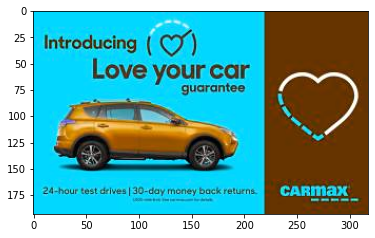

In [ ]:
plt.imshow(duplicates[6])

In [ ]:
FLAG_6 = True

while FLAG_6:
  #  creating a list to hold duplicates
  all_duplicates = []

  #  looping through all files
  for file in tqdm(os.listdir(parent_dir)):
    #  reading all image files
    image_instance = cv2.imread(os.path.join(parent_dir, file))
    #  looping through all images to be checked
    for item in duplicates:
      #  comparing arrays 
      check = np.array_equal(image_instance,item)
      if check:
        #  appending duplicate to list if condition holds true
        all_duplicates.append(file)
  print(f'\nTotal number of duplicates: {len(all_duplicates)}')
  break

100%|██████████| 20332/20332 [07:47<00:00, 43.46it/s] 


Total number of duplicates: 55


In [ ]:
#  deleting duplicates
FLAG_7 = True

while FLAG_7:
  for instance in tqdm(all_duplicates):
    try:
      os.remove(os.path.join(parent_dir, instance))
    except FileNotFoundError:
      pass
  break

100%|██████████| 55/55 [00:00<00:00, 337.32it/s]


In [ ]:
#  checking the number of unique images
FLAG_9 = True

while FLAG_9:
  file_names = []
  images_left = 0
  for file in tqdm(os.listdir('gdrive/My Drive/Datasets/Car_Images/sedans')):
    images_left+=1
    file_names.append(file)
  print(f'\ntotal: {images_left}')
  print(f'last image: {file_names[-1]}')
  break

100%|██████████| 20291/20291 [00:00<00:00, 718957.74it/s]


total: 20291
last image: sedan_46212.jpg


## Sample Image

In [ ]:
sample = cv2.imread('coupe_13240.jpg')

Image shape: (238, 318, 3)


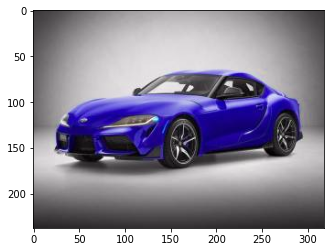

In [ ]:
print(f'Image shape: {sample.shape}')
plt.imshow(sample)

In [ ]:
sample.shape

(238, 318, 3)

In [ ]:
#with np.printoptions(threshold=np.inf):
    #print(sample[:,:,0])